# Курсовая по курсу Data Science (Финал)

Выкинул все рассуждения и провреку, оценку показателей так чтобы сосредаточится на последней части, немного переделал функцию, способ вызова функции подготовки значений

In [677]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [678]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline

In [679]:
import warnings
warnings.simplefilter('ignore')

In [680]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [681]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Тут функции у нас будут с помощью которых мы будем обрабатывать наши колонки и приводить их к нужному виду

In [682]:
 def my_prepare_dataset(cdf, col):
    if (col == 'Home Ownership'):
        # прировняем 'Home Mortgage' к "Have Mortgage".
        cdf.loc[cdf[col] == 'Have Mortgage', col] = 'Home Mortgage'
        
    elif (col == 'Annual Income'):
        #Обрабатываем годовой доход        
        #Добавим свою колонку с полему указан доход или нет 
        cdf.loc[cdf[col].isnull() , 'Revenue set'] = 0
        cdf.loc[cdf[col] == 0 , 'Revenue set']     = 0
        
        cdf.loc[cdf[col] > 0 , 'Revenue set']     = 1
        
        #и заменим сам доход с NaN на 0
        cdf.loc[cdf[col].isnull() , col] = 0
        
        cdf['Revenue set'] = cdf['Revenue set'].astype('int32')
    elif (col == 'Years in current job'):
        #Ставим значения на месте работы, на моду, но только там, где указан годовой доход
        cdf.loc[(cdf[col].isnull()) & (cdf['Annual Income']==0), col] = '-1'
        cdf.loc[(cdf[col].isnull()) & (cdf['Annual Income']>0) , col] = cdf[col].mode()[0]
         
        #Подготовим данные для преобразования в число
        cdf.loc[cdf[col] == '< 1 year', col] = '0 year';
        
        #Теперь заменим года, чтобы перейти на числове значений
        cdf[col] = cdf[col].astype(str)
        cdf[col] = pd.to_numeric(cdf[col].str.replace(r'[^0-9\-]', ''), errors='coerce') 
        cdf[col] = cdf[col].astype('int32')
        
    elif (col == 'Tax Liens'):
        cdf.loc[cdf[col]>7, col] = 7
        
    elif (col == 'Maximum Open Credit'):
        cdf['Debt load'] = 0
        cdf.loc[cdf['Annual Income']>0 , 'Debt load'] = cdf.loc[cdf['Annual Income']>0 , 'Maximum Open Credit']/cdf.loc[cdf['Annual Income']>0 , 'Annual Income'] 
    
    elif (col == 'Number of Credit Problems'):
        cdf.loc[cdf[col]>7, col] = 7
    
    elif (col == 'Months since last delinquent'):
        cdf.loc[cdf[col].isnull() , col] = 0
    
    elif (col == 'Bankruptcies'):
        cdf.loc[cdf[col].isnull() , col] = cdf[col].mode()[0]
        
        #И ещё добавим све поле, которое будет делить всё просто на два класса
        cdf['Bankruptcies Flag'] = 1
        cdf.loc[cdf[col] == cdf[col].mode()[0] , 'Bankruptcies Flag'] = 0
        
        # И уберем значения которые вышли за рамки того что естьтренировочном дата сете  
        cdf.loc[cdf[col]>4, col] = 4
        
    elif (col == 'Purpose'):
        if col in cdf:
            # Если надо, то сделаем слияние маленьких признаков
            if not('All others' in cdf[col].value_counts()):
                # Значит нет ещё моего признака, и нужно сделать обработку
                tmp_values = dict(cdf['Purpose'].value_counts().copy())

                for i in range(4,len(tmp_values)):
                    cdf.loc[cdf[col] == list(tmp_values.keys())[i] , col] = 'All others'
                    #print (list(tmp_values.keys())[i])
                    
    elif (col == 'Term'):
        tmp_values = dict(cdf['Term'].value_counts().copy())
        
        cdf.loc[cdf[col] == list(tmp_values.keys())[0] , col] = 0
        cdf.loc[cdf[col] == list(tmp_values.keys())[1] , col] = 1
        
        cdf[col] = cdf[col].astype('int32')
        
    elif (col == 'Current Loan Amount'):
        pass
    
    elif (col == 'Monthly Debt'):
        pass
    
    elif (col == 'Credit Score'):
        #Добавим свое поле с тремя значениями, -1 кредитного рейтинга нет, 0 - рейтинг близко к нулю, и 1-высокий 
        #порог отсечения пока условный в 2048 пнукта
        if not('Credit Score My flag' in cdf):
            cdf['Credit Score My flag'] = 1
            cdf.loc[cdf[col].isnull() , 'Credit Score My flag'] = -1
            cdf.loc[cdf[col]<=2048 , 'Credit Score My flag'] = 0
        
        #И теперь заменяем пропуски в самой выборке
        cdf.loc[cdf[col].isnull() , col] = 0

In [683]:
def my_dummy_prepare(cdf, col, nameslice):
    #Проверяем что надо приобразовать, что это перменная есть в датасете 
    if col in cdf: 
        cdf = pd.get_dummies(cdf, prefix=col, columns=[col], dtype=bool)
    
    #И удалим не нужню колонку
    full_name_drop = col+'_'+nameslice
    if full_name_drop in cdf:
        cdf = cdf.drop(columns=full_name_drop)
        
    return cdf    

In [799]:
pd.set_option('display.max_columns', None)

# input
DATASET_PATH = 'course_project_train.csv'
DATASET_TEST_PATH = 'course_project_test.csv'

# output
#PREP_DATASET_PATH = '../training_project_data_prep.csv'
# output
TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

MODEL_FILE_PATH = 'scaler_ff_model.pkl'
SCALER_FILE_PATH = 'scaler.pkl'

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [685]:
df = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(DATASET_TEST_PATH)

In [686]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [687]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


## Обзор данных и их предобработка

In [688]:
for colname in df.columns:
    #print(colname)
    my_prepare_dataset(df,colname)
    my_prepare_dataset(df_test,colname)
    

В итоге у нас появились новые, наши поля:

* **Revenue set** 0 если доход годовой не указан и 1 если указан
* **Debt load** как отношение кредитов к годовому доходу, если годовой доход есть
* **Bankruptcies Flag** которое просто 0 или 1. 1 всё что не 0 в Bankruptcies
* **Credit Score My flag** свой рейтинг в котором -1, если его нет - 0, если он не выше порога определнного и 1 если выше этого порога

Тут уже имеем подготовленные и обработанные данные для двух выборок. Ниже делаем превращение нужных нам переменных в DUMMY

### Превратили категории в DUMMY признаки

In [689]:
for colname in df.select_dtypes(include=['object']).columns:
    
    #для каждой колонки, на основне основного дата сета определим 
    #имя колонки, которую потом будем убирать, чтобы сократить кол-во DUMMY переменнных
    #colname = 'Home Ownership'
    tmp_values = dict(df[colname].value_counts().copy())
    nameslice_for_delet = list(tmp_values.keys())[len(tmp_values)-1]
    #print(nameslice_for_delet)    

    df      = my_dummy_prepare(df,     colname,nameslice_for_delet)
    df_test = my_dummy_prepare(df_test,colname,nameslice_for_delet)

In [690]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Revenue set,Debt load,Bankruptcies Flag,Credit Score My flag,Home Ownership_Home Mortgage,Home Ownership_Rent,Purpose_All others,Purpose_debt consolidation,Purpose_home improvements,Purpose_other
0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,99999999.0,47386.0,7914.0,749.0,0,1,1.422897,1,0,False,False,False,True,False,False
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,1,264968.0,394972.0,18373.0,737.0,1,1,1.152360,0,0,False,False,False,True,False,False
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,99999999.0,308389.0,13651.0,742.0,0,1,1.573616,0,0,True,False,False,True,False,False
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,0,121396.0,95855.0,11338.0,694.0,0,1,0.183090,1,0,False,False,False,True,False,False
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,0,125840.0,93309.0,7180.0,719.0,0,1,0.497042,0,0,False,True,False,True,False,False


И ещё на финал, превратим в булевые значения признаки которые у нас такими и являются
Сделаем это просто руками, вдруг для другой моделе нужны будут INT значения

In [691]:
BOOL_COL = ['Term','Revenue set','Bankruptcies Flag','Credit Score My flag']

for colname in BOOL_COL:            
    df[colname]      = df[colname].astype(bool)
    df_test[colname] = df_test[colname].astype(bool)



## Смотрим уже предметно показатели

Этот кусок тут оставил, из предыдущего анализа

### "Credit Default". Собсвтенно наша целевая переменная

In [692]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

На всякий случай посмотрел что нет значений других кроме 0 и 1 :)

In [693]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

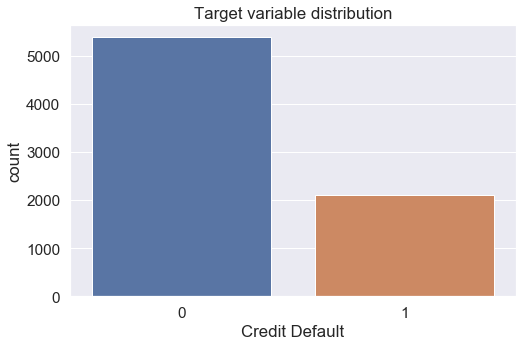

In [694]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

Дисбаланс у нас тут тоже есть, как и в уроке. Что понятно. На сколько я понял, такой дисбаланс говорить нам о том, что "легче" будет предсказать 0 чем 1. И опять таки, на сколько я понял, нам это нужно прежде всего для того чтобы понимать как раз для того, чтобы потом "двигать" F-функцию

Так, посмотрим на то, какие показатели будут коллерировать с нашей целевой переменной

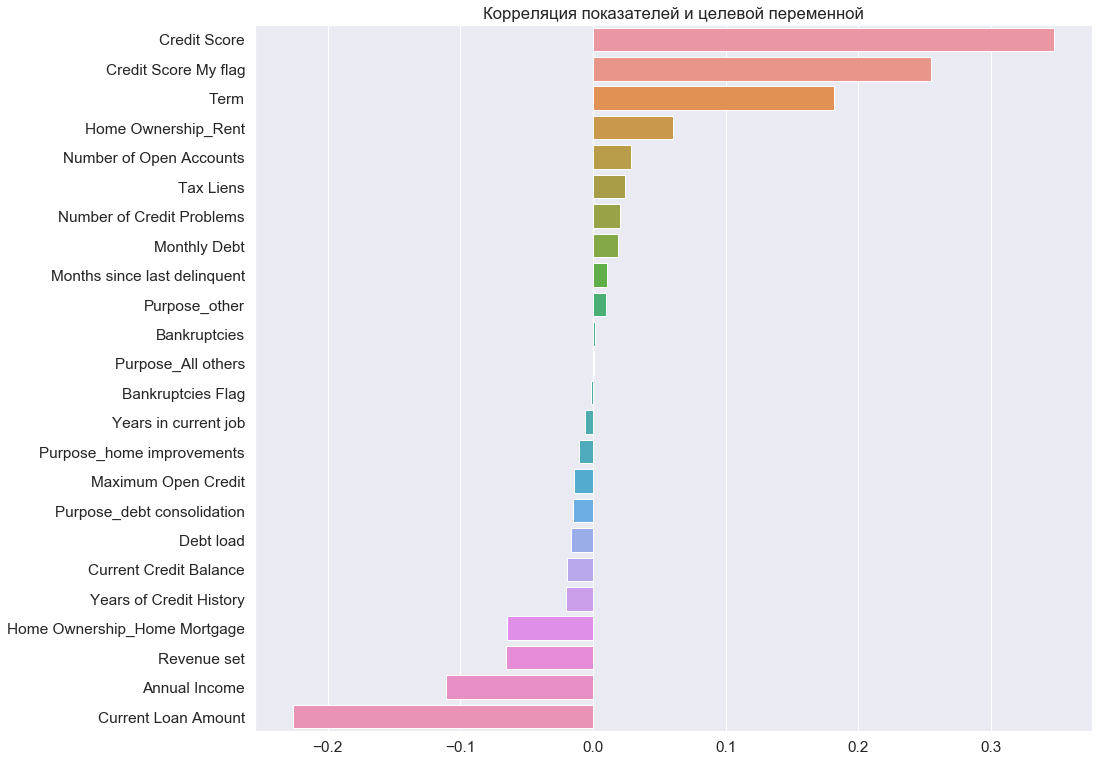

In [695]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(15, 13))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция показателей и целевой переменной')
plt.show()

Вот у нас выделились явные лидеры, которые нам надо рассмотреть: Credit Score и Term с положительной корреляцией и Credit Score My Flag, Revenue Set, Annual Income, Curent Loan Amount -  с отрицательной

Потому смотрим на каждый из них в отдельности

### Оценка признака "Credit Score" в разрезе целевой переменной

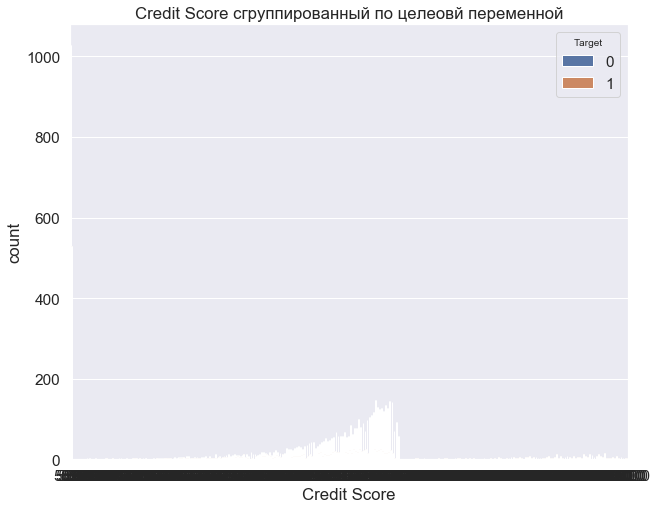

In [696]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df)
plt.title('Credit Score сгруппированный по целеовй переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Так как у нас там много разных значений, то для визульного анализа будем использовать другой метод. Туд ничего не видно :)

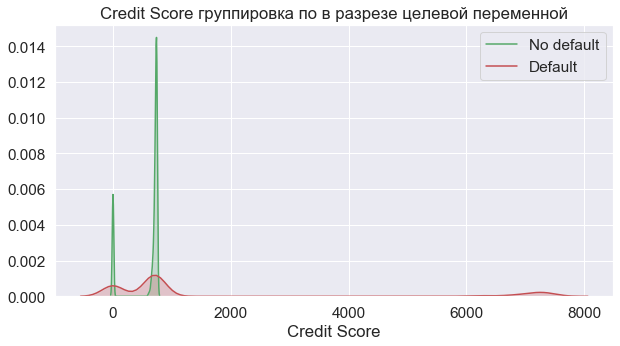

In [697]:
#Получили сулчайную выборку строк и по двум колонкам
sc_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
sc_s = sc_with_target_s['Credit Score']

# разделили значения по двум графикам 
sc_target_0 = sc_s[sc_with_target_s[TARGET_NAME] == 0]
sc_target_1 = sc_s[sc_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(sc_target_0, shade=True, label='No default', color='g')
sns.kdeplot(sc_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score группировка по в разрезе целевой переменной')
plt.show()

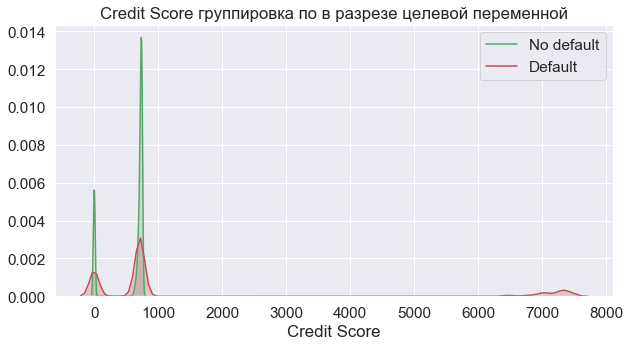

In [698]:
sc_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
sc_s = sc_with_target_s['Credit Score']
sc_target_0 = sc_s[sc_with_target_s[TARGET_NAME] == 0]
sc_target_1 = sc_s[sc_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(sc_target_0, shade=True, label='No default', color='g')
sns.kdeplot(sc_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score группировка по в разрезе целевой переменной')
plt.show()

Зафиксировал несколько разных семплов, они показательны как раз.
На сколько я понимаю, это не безумно хорошо, так как по вертикали у нас частота, то нам их сложно будет разделить.
Не считая правого всплеска, можно было бы попытаться разбить на два отдельных множества, которые были бы а-ля нормальные, но тоже не вижу что это даст, так как не поможет задачи классификации этого признака 

Но, возможно я не прав, и не так трактую график, потому проверим этот показатель как делали в уроке
Сначала проверим на нормальность, для успокоения души

In [699]:
shapiro(sc_s)

(0.3591597080230713, 0.0)

Вот с гипотезами пока как то тяжко, видимо надо вертеть эти данные вкуча разрезах, чтобы и проверять чуть ли не по всем критерям, чтобы найти что-то. Но вот что, с мат ожиданием понятно. Если у нас будет два разных мат ожидания для двух этих классов, то когда прилетит значение этой переменной, мы сможем с уверенноостью в 95 процентов сказать как это повлияете на целевую переменную

Какие ещё могут быть гипотезы, пока сложно предположить. Потому как тут визуально матожидания будут где-то рядом.

#### Наблюдение
Визуально различия есть, проверяем, мат ожидания у них будут равны или нет 

#### Гипотеза

* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: с помощью критерия Манна-Уитни
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [700]:
mannwhitneyu(sc_target_0, sc_target_1)

MannwhitneyuResult(statistic=96549.5, pvalue=0.0730708011173208)

pvalue получилось не сильно меньше даже больше ) видимо не очень хорошо ) посмотрим тоже на графике

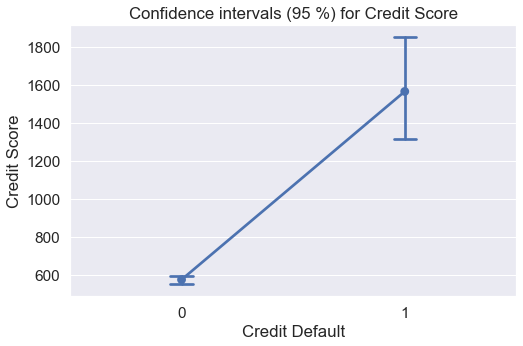

In [701]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=sc_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

Так, а вот по графику, всё получается прям ну очень хорошо. Получается мы можем отвергунть нулевую гипотезу, о том что мат ожидания равны, так как у них не плохой разброс 

<b>Вопрос</b>:Гипотеза могла же быть и наоборот высказана, нулевая гепотеза могла быть названа "Мат ожидания не равны", уровень значимости наверное тогда был 0.95? Но что от этого поменялось, выборка была таже, mannwhitneyu вернул бы теже значения. Возможно их интерпритировать нужно было бы по другому. И визуально график бы не поменялся, так как мы просто раздили имеющиеся у нас данные. Потому совсем пока не понял зачем мне нужна была гипотеза :(

#### Оценка признака "Term" в разрезе целевой переменной

In [702]:
df['Term'].value_counts()

False    5556
True     1944
Name: Term, dtype: int64

Он у нас всего из двух значений, занчит его посмотрим как раз в частоном разрезе

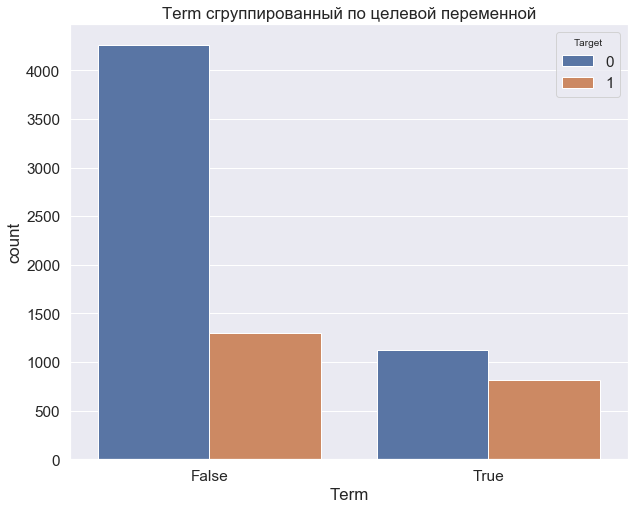

In [703]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET_NAME, data=df)
plt.title('Term сгруппированный по целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Видно что высокий процент Term=1 превращает нашу целевую переменную. Это хорошо, какие-то доп оценки видимо делать нет смысла

#### Оценка признака "Term" в разрезе целевой переменной

In [704]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

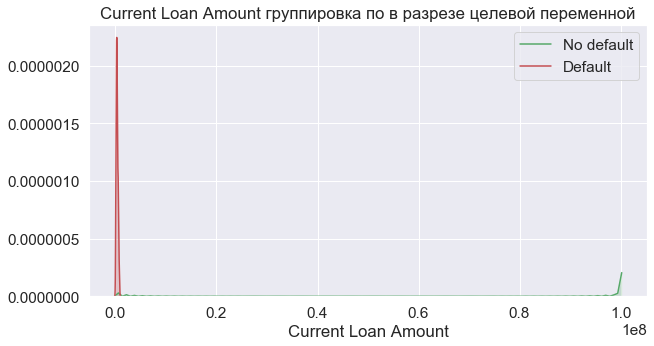

In [705]:
#Получили сулчайную выборку строк и по двум колонкам
cla_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
cla_s = cla_with_target_s['Current Loan Amount']

# разделили значения по двум графикам 
cla_target_0 = cla_s[cla_with_target_s[TARGET_NAME] == 0]
cla_target_1 = cla_s[cla_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cla_target_0, shade=True, label='No default', color='g')
sns.kdeplot(cla_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount группировка по в разрезе целевой переменной')
plt.show()

In [706]:
shapiro(cla_s)

(0.3799535632133484, 0.0)

Распределение не нормальное, посмотрим в этот раз визально, как в уроке.

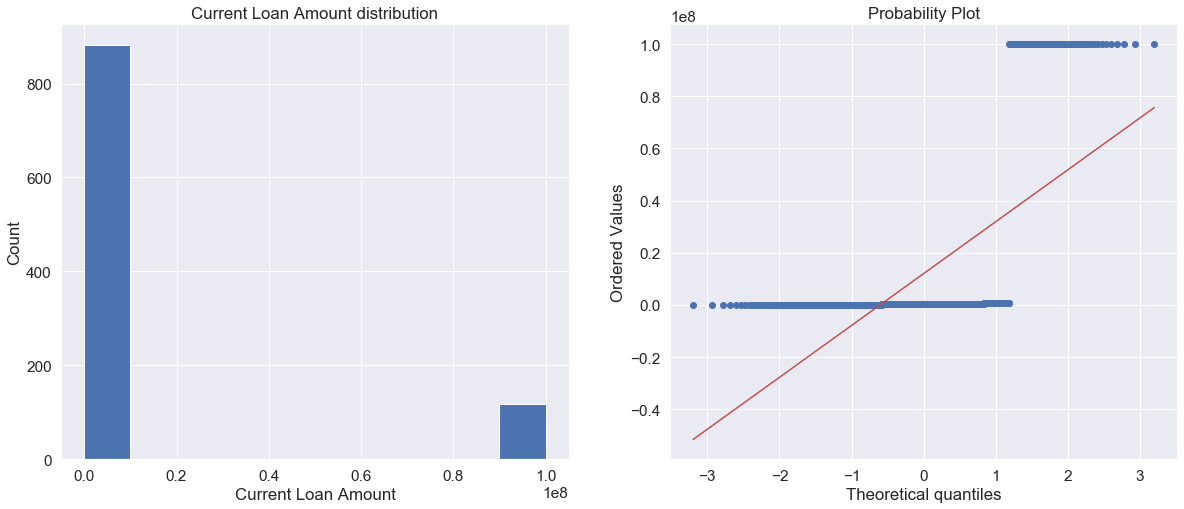

In [707]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
cla_s.hist()

plt.subplot(122)
probplot(cla_s, dist='norm', plot=plt)

plt.show()

Хорошее распределение для разделения судя по графику

#### Оценка признака "Term" в разрезе целевой переменной

In [708]:
df['Annual Income'].value_counts()

0.0          1557
1161660.0       4
1058376.0       4
1043651.0       4
1338113.0       4
             ... 
1141254.0       1
7907382.0       1
1534478.0       1
972040.0        1
585751.0        1
Name: Annual Income, Length: 5479, dtype: int64

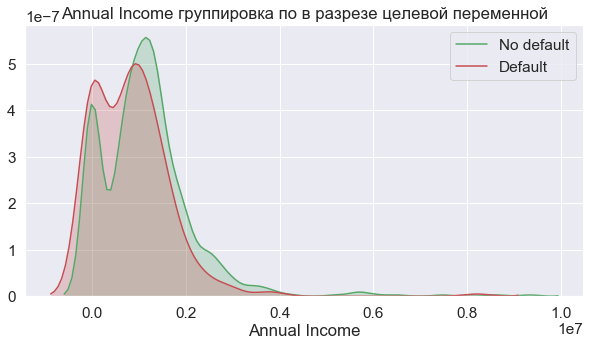

In [709]:
#Получили сулчайную выборку строк и по двум колонкам
ai_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
ai_s = ai_with_target_s['Annual Income']

# разделили значения по двум графикам 
ai_target_0 = ai_s[ai_with_target_s[TARGET_NAME] == 0]
ai_target_1 = ai_s[ai_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(ai_target_0, shade=True, label='No default', color='g')
sns.kdeplot(ai_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income группировка по в разрезе целевой переменной')
plt.show()

Кажется очень похожими, посмотрим что там с мат ожиданиями

In [710]:
mannwhitneyu(ai_target_0, ai_target_1)

MannwhitneyuResult(statistic=79975.5, pvalue=2.702780115137916e-07)

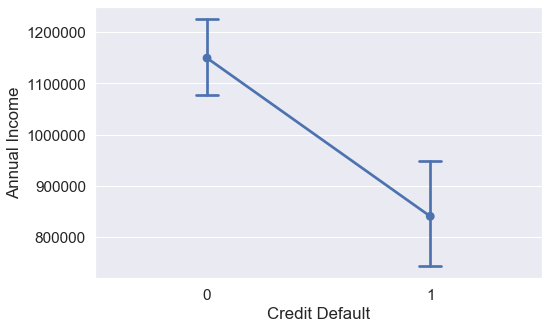

In [711]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=ai_with_target_s, capsize=.1)

##plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

#### Оценка признака "Revenue set" в разрезе целевой переменной

In [712]:
df['Revenue set'].value_counts()

True     5943
False    1557
Name: Revenue set, dtype: int64

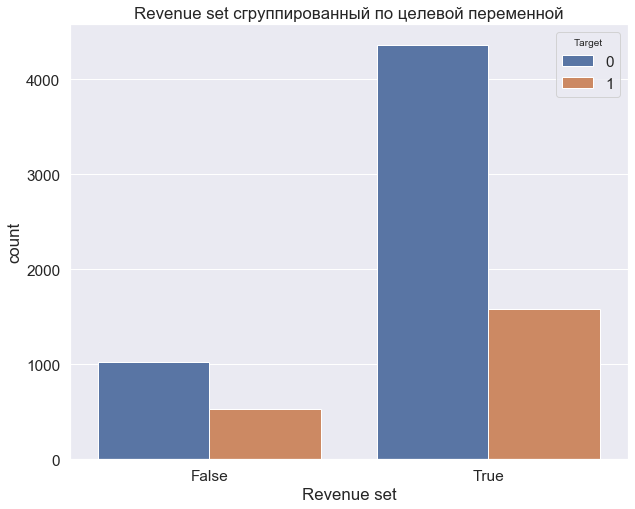

In [713]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Revenue set", hue=TARGET_NAME, data=df)
plt.title('Revenue set сгруппированный по целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Ну вот такое влияние этой переменной на целевую переменную. Не вижу что тут можно и навреное и не нужно делать ничего  

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций** (добавил, так как не сделал после второго видео)

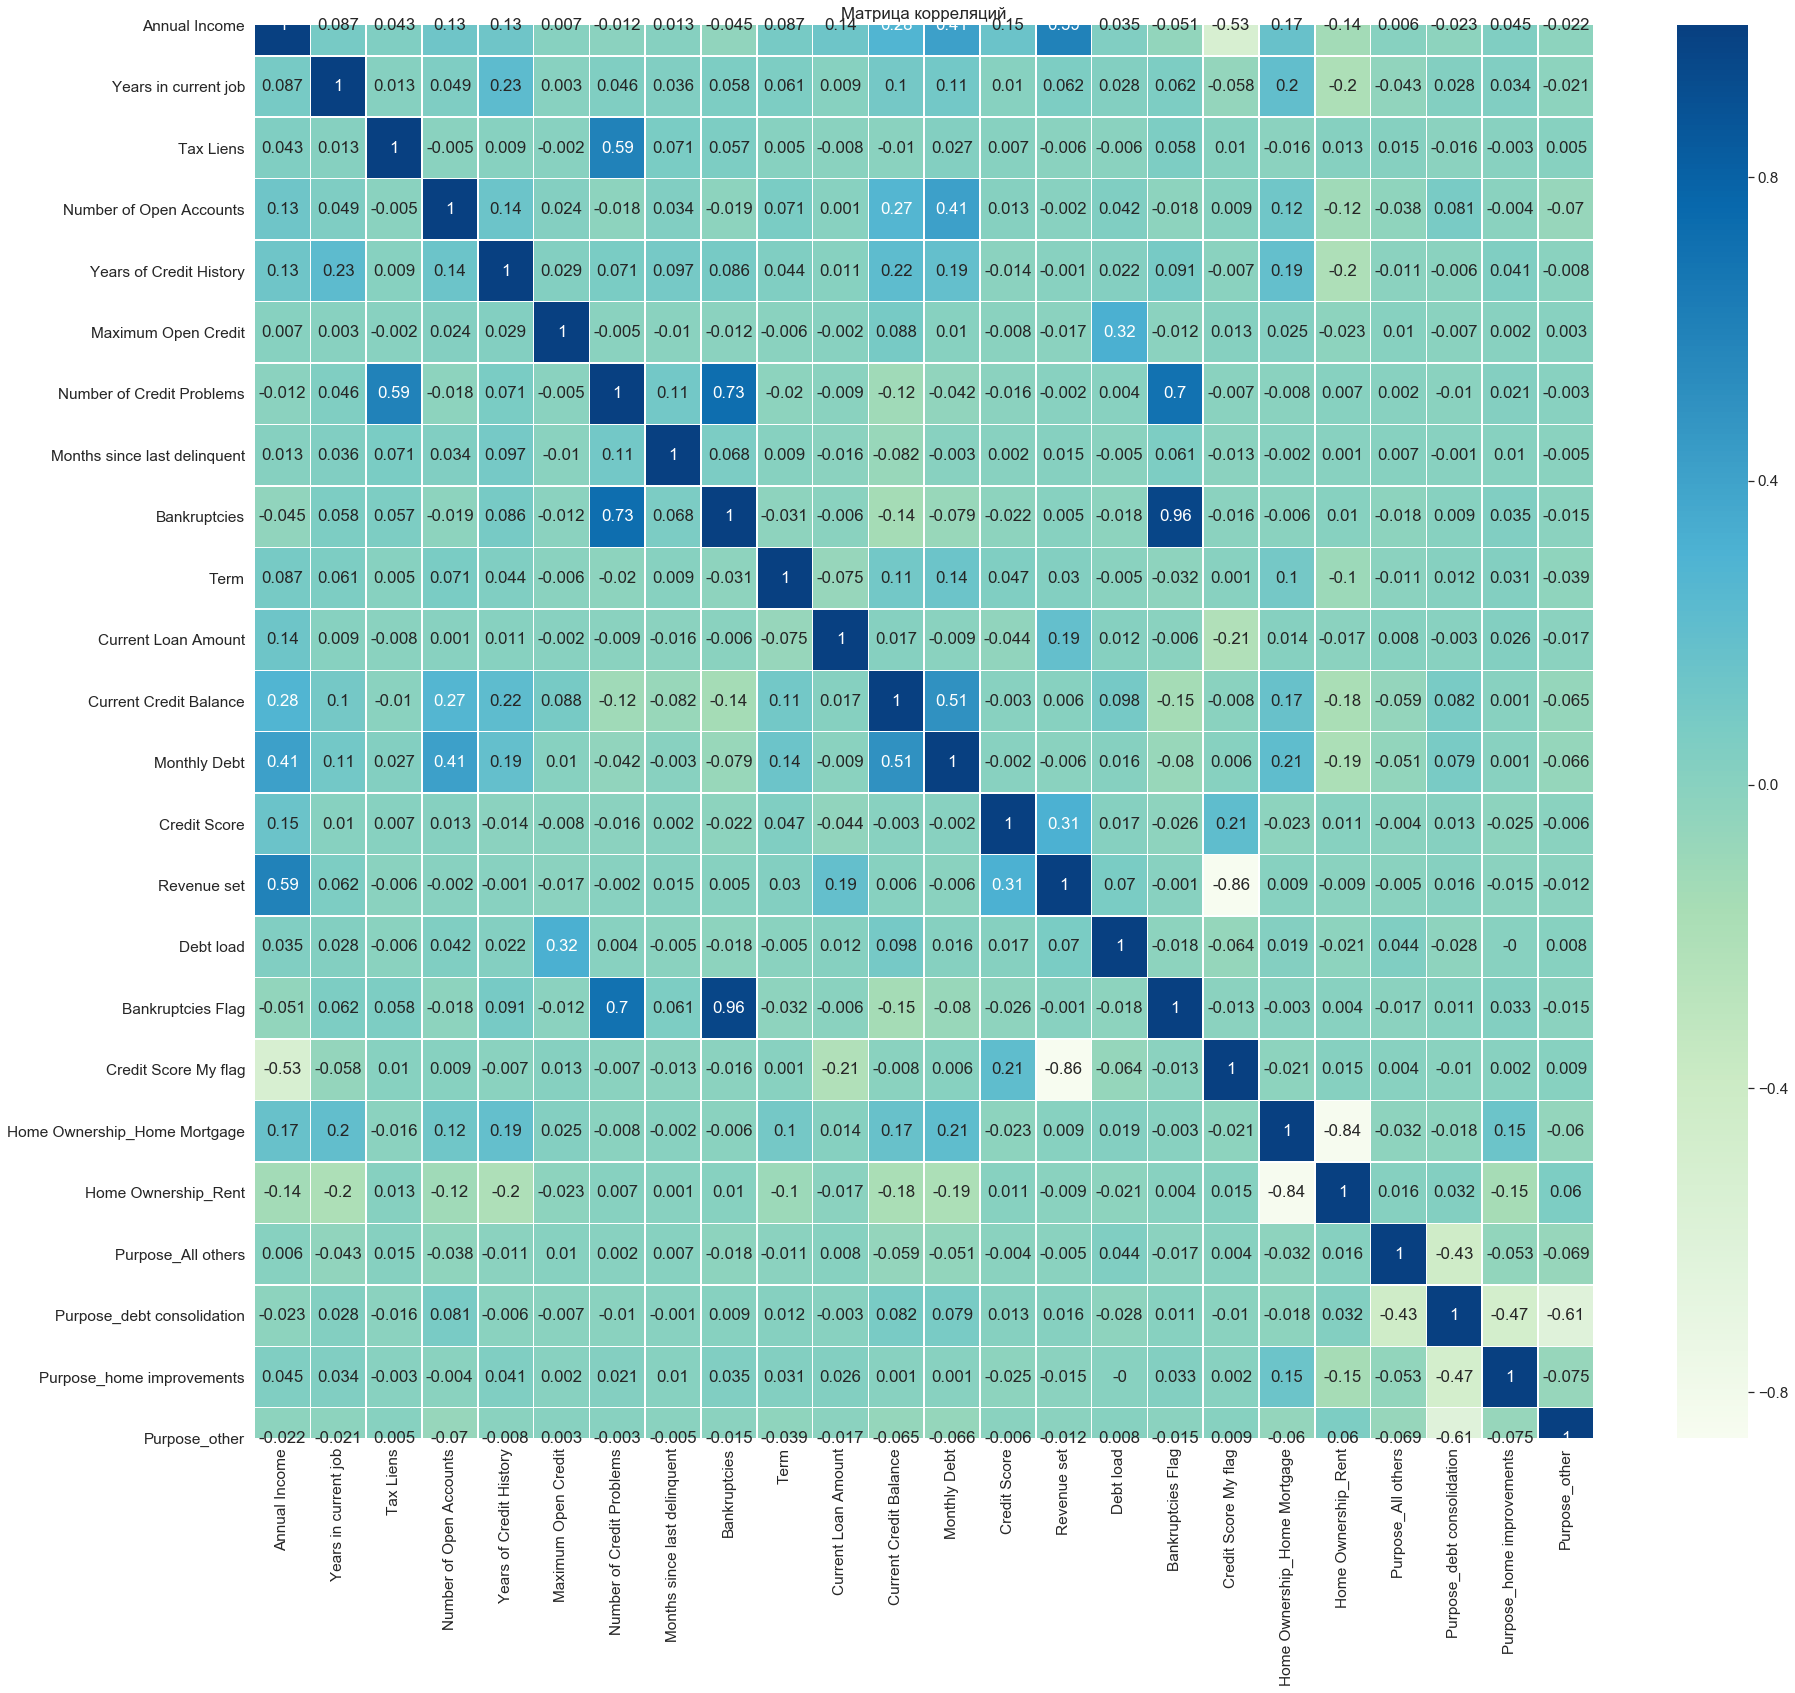

In [714]:
plt.figure(figsize = (30,26))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций')
plt.show()

Есть прям хорошо коррелированные признаки. Это две пары: <b>Bankruptcies</b> и <b>Bankruptcies Flag</b>, а также <b>Revenue set</b> и <b>Credit Score My flag</b>

При этом история с <b>Bankruptcies</b>, после выбора финальной модели можно будет попробовать эту модель без одного из этих полей. и посмотреть что будет лучше.  

А вот со второй парой интеремнее, так как это два моих введнных, флага. Вначале там корреляция была вообще 1, но потом я изменил способо формирования Credit Score My flag увеличив порог. Думаю поле выбора финально модели я его ещё увеличу, чтобы уменьшит корреляцию этх двух переменных. 

**UPD:** сразу решил кикнуть Bankruptcies, чтобы так как там много пропусков. Оставлю только свой флаг


In [715]:
#if 'Bankruptcies' in BASE_FEATURE_NAMES:
#    BASE_FEATURE_NAMES.remove('Bankruptcies')

#if 'Bankruptcies' in df:
#    df = df.drop(columns='Bankruptcies')

#if 'Bankruptcies' in df_test:
#    df_test = df_test.drop(columns='Bankruptcies')


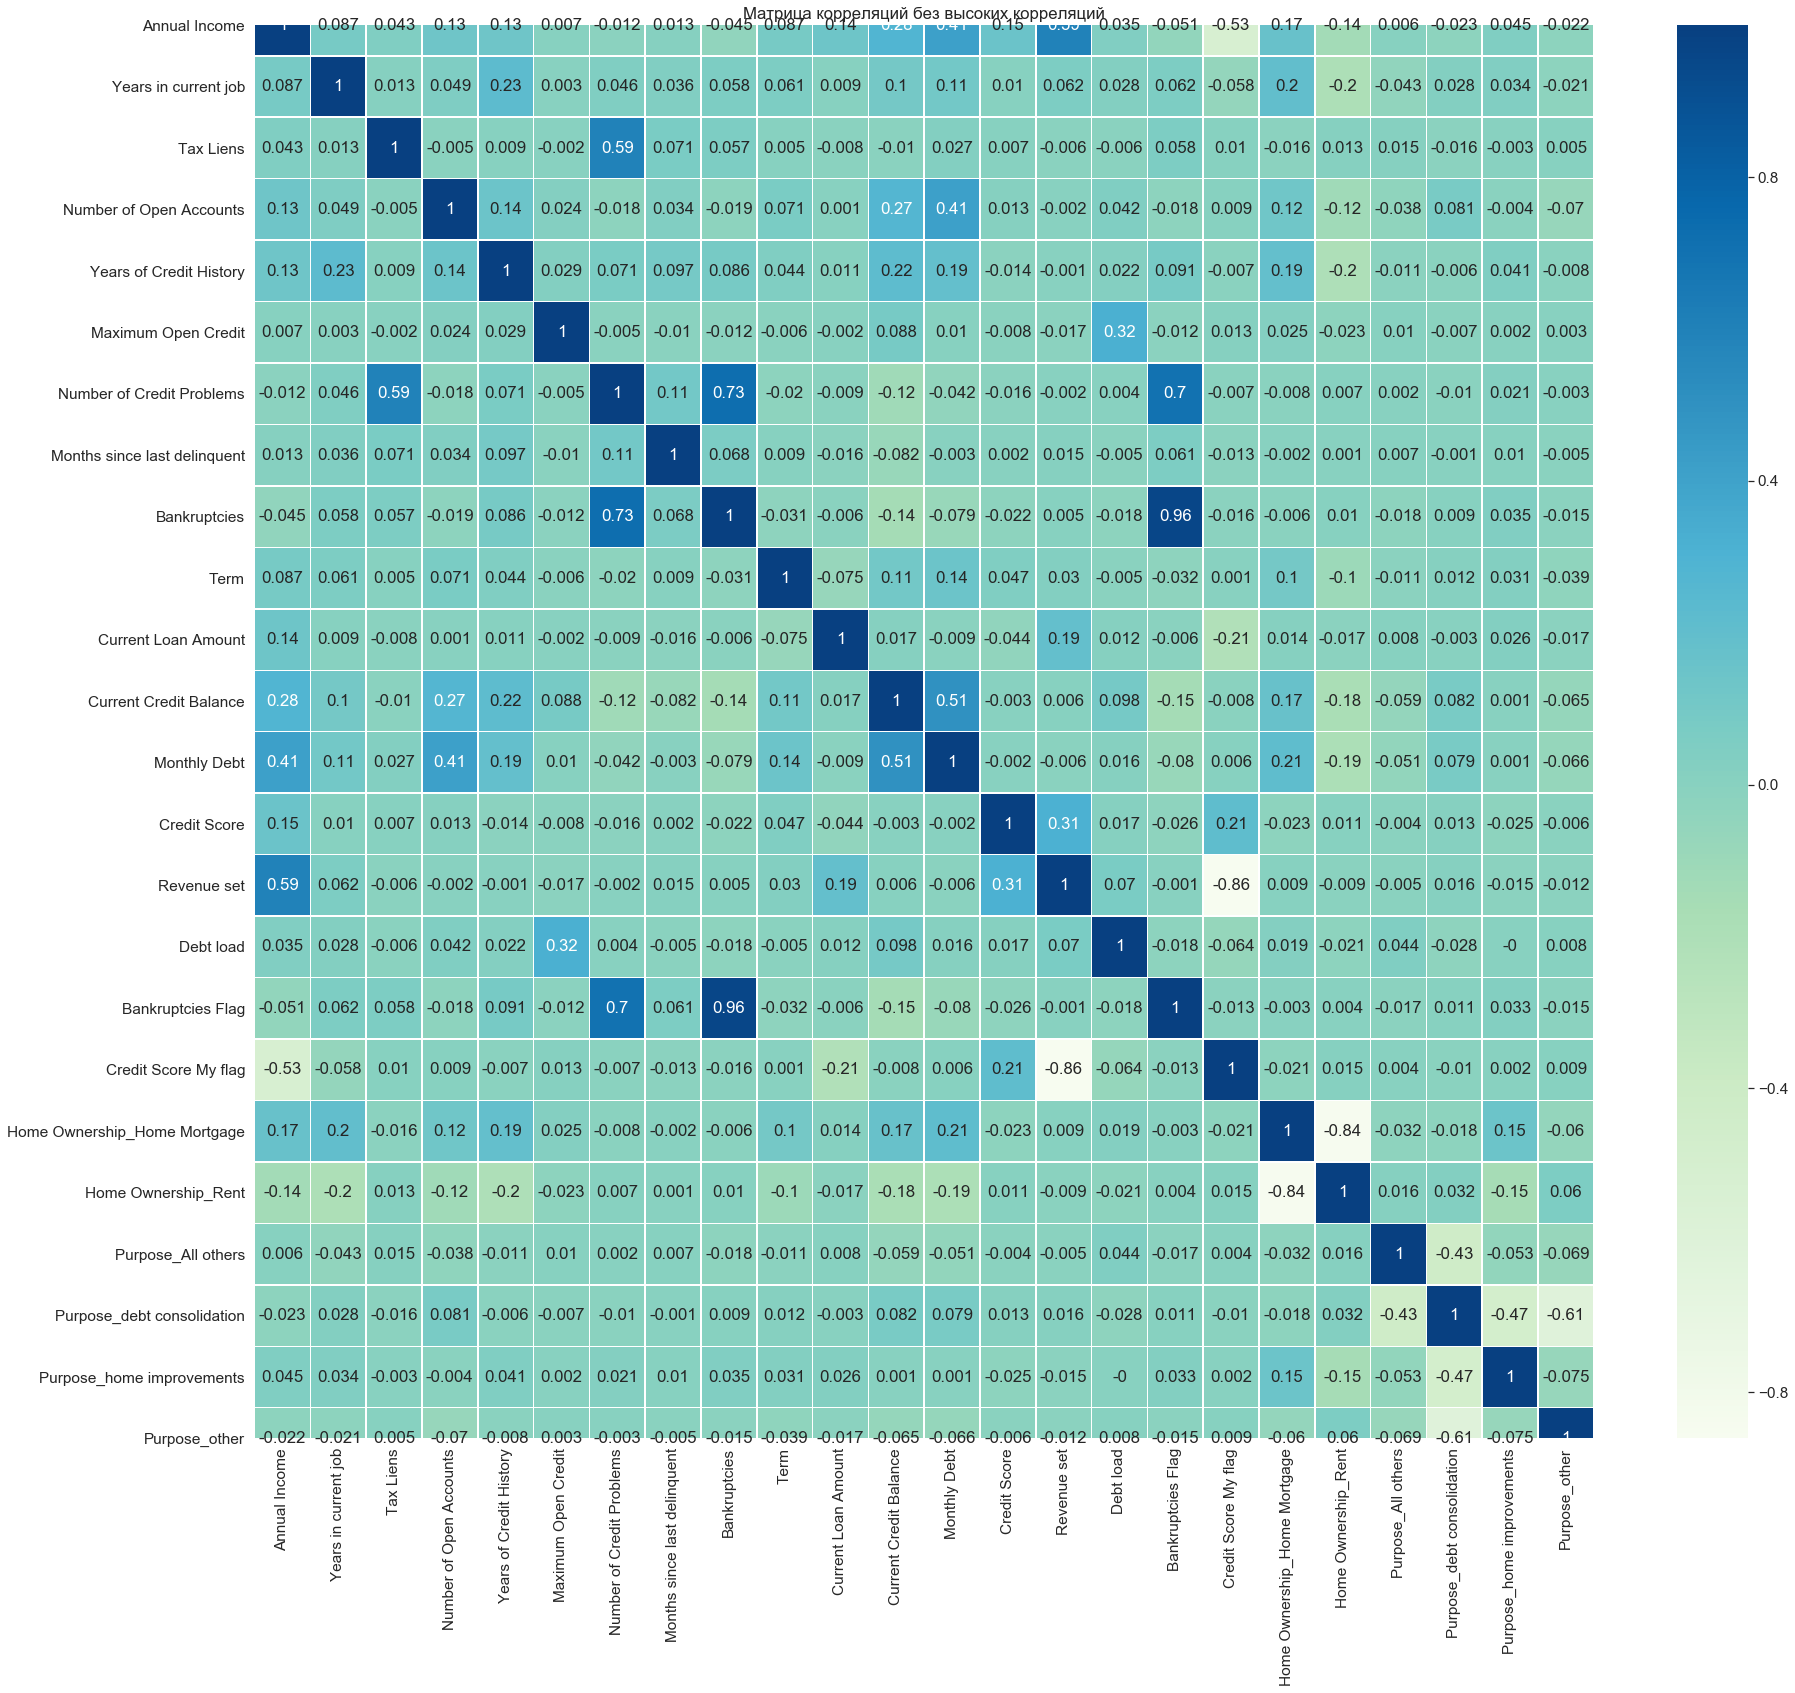

In [716]:
plt.figure(figsize = (30,26))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций без высоких корреляций')
plt.show()

## Выбираем модель для предсказания целевой переменной 

В предыдущих версиях делал там выбор и сравнение разных моделей, пока остановился тоже на CATBUST чтобы не распылять свой учебный ресурс :) Сравнение убрал от сюда, чтобы не загромаждать

Все провреки которые были в этой части уже учтены в функции подготовки данных

### Отбор признаков<a class="anchor" id="feature_selection"></a>

Разделил всё руками смотря в каждое поле по отдельности через value_counts(), при этом выделим только те колонки
которые у нас попадаут под нормализацию

Остальные мы автоматом отнесем к категориальным, чтобы было меньше ошибок с пропусками колонок
Тем более что при превращении в DUMMY мы выкидываем колонку с наименьшим значением

In [717]:
#Отобраны те, которые мы подврегаем нормализации 
NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                     'Current Loan Amount','Current Credit Balance','Monthly Debt',
                     'Debt load']

#Все остальные, за минусом целевой переменной, которые становятся категориальными 
CAT_FEATURE_NAMES = list(set(df.columns) - set(NUM_FEATURE_NAMES) - set([TARGET_NAME])) 

#Все признаки за минусом целевой пемеменной
SELECTED_FEATURE_NAMES = list(set(df.columns) - set([TARGET_NAME]))

### Приведение типов для модели CatBoost

In [718]:
for colname in CAT_FEATURE_NAMES:
    df[colname]      = pd.Categorical(df[colname])
    df_test[colname] = pd.Categorical(df_test[colname])
    
    
df[CAT_FEATURE_NAMES].dtypes

Purpose_home improvements       category
Credit Score                    category
Purpose_All others              category
Term                            category
Purpose_other                   category
Home Ownership_Rent             category
Bankruptcies                    category
Credit Score My flag            category
Tax Liens                       category
Years in current job            category
Number of Credit Problems       category
Revenue set                     category
Months since last delinquent    category
Bankruptcies Flag               category
Home Ownership_Home Mortgage    category
Purpose_debt consolidation      category
dtype: object

In [719]:
#for colname in df.select_dtypes(include=['object']).columns:
    #print(colname)
#    df[colname] = df[colname].astype(str)
    #сразу сделаем и для второго набора
#    df_test[colname] = df_test[colname].astype(str)

### Нормализация данных<a class="anchor" id="normalization"></a>

На всякий случай посмотрим те колонки, которые мы будем нормализовать

In [720]:
df[NUM_FEATURE_NAMES].head()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Debt load
0,482087.0,11.0,26.3,685960.0,99999999.0,47386.0,7914.0,1.422897
1,1025487.0,15.0,15.3,1181730.0,264968.0,394972.0,18373.0,1.152360
2,751412.0,11.0,35.0,1182434.0,99999999.0,308389.0,13651.0,1.573616
3,805068.0,8.0,22.5,147400.0,121396.0,95855.0,11338.0,0.183090
4,776264.0,13.0,13.6,385836.0,125840.0,93309.0,7180.0,0.497042


In [721]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [722]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Revenue set,Debt load,Bankruptcies Flag,Credit Score My flag,Home Ownership_Home Mortgage,Home Ownership_Rent,Purpose_All others,Purpose_debt consolidation,Purpose_home improvements,Purpose_other
0,-0.642744,10,0.0,-0.026674,1.133645,-0.016174,1.0,0.0,1.0,False,2.760520,-0.762772,-0.872085,749.0,0,True,0.268776,True,False,False,False,False,True,False,False
1,-0.061254,10,0.0,0.788223,-0.428528,0.014763,0.0,0.0,0.0,True,-0.363620,0.330781,0.004909,737.0,1,True,0.191571,False,False,False,False,False,True,False,False
2,-0.354541,8,0.0,-0.026674,2.369181,0.014807,0.0,0.0,0.0,False,2.760520,0.058379,-0.391034,742.0,0,True,0.311788,False,False,True,False,False,True,False,False
3,-0.297124,6,0.0,-0.637847,0.593985,-0.049781,1.0,0.0,1.0,False,-0.368118,-0.610282,-0.584980,694.0,0,True,-0.085038,True,False,False,False,False,True,False,False
4,-0.327947,8,0.0,0.380774,-0.669954,-0.034902,1.0,0.0,0.0,False,-0.367978,-0.618292,-0.933631,719.0,0,True,0.004557,False,False,False,True,False,True,False,False


**Сохранение модели для нормализации данных**

In [723]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [724]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=43)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [725]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

In [726]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [727]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [728]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a>  CatBoost


### Подгрузим Здесь данные обратно, чтобы тренироваться с разными параметрами модели

Если что-то будем делать с полями, то надо не забыть это сделать для обои выборок

In [729]:
df = pd.read_csv(TRAIN_FULL_PATH)
train = pd.read_csv(TRAIN_PART_PATH)
test = pd.read_csv(TEST_PART_PATH)

#Перед тренировкой снова превращаем их в четыре переменные, которые используются у нас для модели
X_train = train[SELECTED_FEATURE_NAMES]
y_train = train[TARGET_NAME]

X_test = test[SELECTED_FEATURE_NAMES]
y_test = test[TARGET_NAME]

In [730]:
#for colname in CAT_FEATURE_NAMES:
#    X_train[colname] = X_train[colname].astype(int)
#    X_test[colname] = X_test[colname].astype(int)

#X_train.dtypes
#X_train

In [731]:
#for colname in COL_NAME_BOOL:
#    X_train[colname] = X_train[colname].astype(bool)
#    X_test[colname]  = X_test[colname].astype(bool)

#for colname in COL_NAME_INT:
#    X_train[colname] = X_train[colname].astype(int)
#    X_test[colname]  = X_test[colname].astype(int)
    

In [732]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=43)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred  = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3795
           1       0.94      0.88      0.91      2910

    accuracy                           0.92      6705
   macro avg       0.92      0.92      0.92      6705
weighted avg       0.92      0.92      0.92      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1592
           1       0.57      0.47      0.52       658

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1355  237
1                346  312


### Подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [733]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=43)

**Подбор гиперпараметров**

In [734]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

In [735]:
params = {'n_estimators':[100, 150, 200, 250, 300, 400, 500, 600, 700, 800],
          'max_depth':[3, 4, 5, 6, 7, 9, 11, 13]}

In [736]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)

In [737]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 13min 45s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001A5E27EC0C8>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 400, 500, 600,
                                                         700, 800]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [738]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 4}

In [739]:
rs.best_score_

0.542370859154999

**Обучение и оценка финальной модели**

In [740]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=4,
                                      silent=True, random_state=43)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      3795
           1       0.82      0.68      0.74      2910

    accuracy                           0.80      6705
   macro avg       0.80      0.78      0.79      6705
weighted avg       0.80      0.80      0.79      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1592
           1       0.54      0.51      0.52       658

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1311  281
1                324  334
Wall time: 669 ms


### Теперь попробуем улучшить эту модель

**Обучение и оценка финальной модели**

Функции тупо взял из урока, потому как почему не использовать то, что уже сделано )

In [741]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [742]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [743]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [778]:
def show_feature_importances(feature_names, feature_importances, get_top=None, no_show_plt=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    
    if no_show_plt is None:  
        
        plt.figure(figsize = (20, len(feature_importances) * 0.6))
    
        sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
        plt.xlabel('Importance')
        plt.title('Importance of features')
    
        plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Снижение степени переобучения

In [852]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=4,
                                      l2_leaf_reg=7,
                                      silent=True, random_state=43)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      3795
           1       0.78      0.52      0.63      2910

    accuracy                           0.73      6705
   macro avg       0.74      0.70      0.71      6705
weighted avg       0.74      0.73      0.72      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1592
           1       0.60      0.47      0.53       658

    accuracy                           0.75      2250
   macro avg       0.70      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1386  206
1                347  311


Чуть подрасла точность с параметром 5-7, не более того  

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [853]:
final_model = catb.CatBoostClassifier(n_estimators=250, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=43)

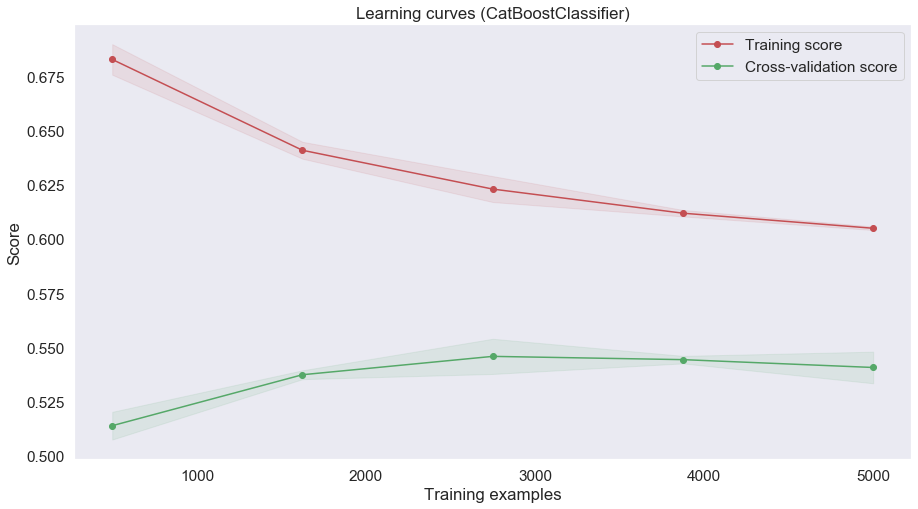

In [854]:
show_learning_curve_plot(final_model, X, y)

Получается что уже около 3000 тысяч примеров у нас перестаетс сильно изменяться ситуация. Хотя не очень понял что нам дало это знание в итоге. Мы выборку не уменьшали, просто получается узнали что могло хватить 3К-4К примеров таких?

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

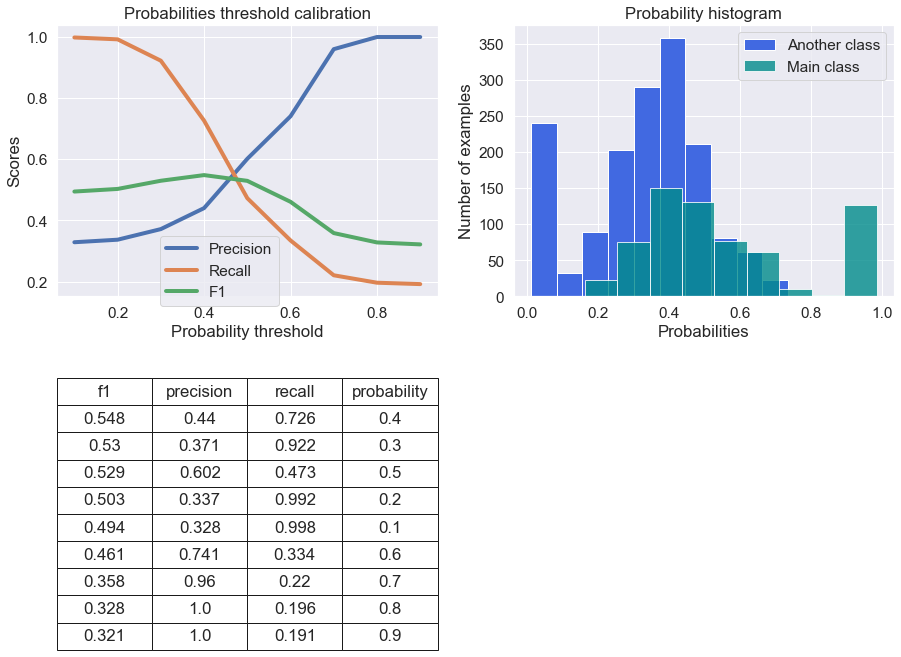

In [855]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Да хорошая табличка вышла, не сразу понял и вспомнил для чего она, но пересмотрел видео, и уже после сохранения предсказанных значений вернулся сюда и попробовал поиграть разными значениями

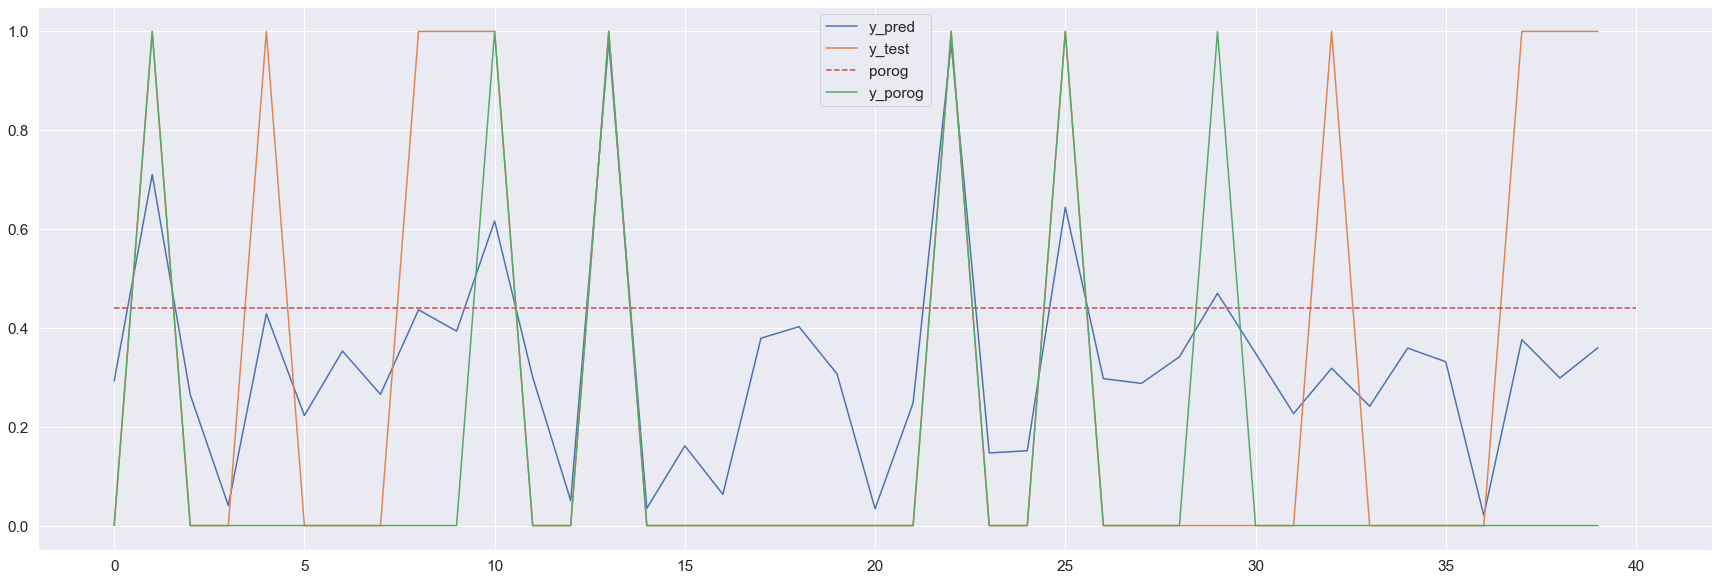

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      3795
           1       0.78      0.52      0.63      2910

    accuracy                           0.73      6705
   macro avg       0.74      0.70      0.71      6705
weighted avg       0.74      0.73      0.72      6705

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1592
           1       0.50      0.61      0.55       658

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1189  403
1                255  403


In [864]:
N=40
porog = 0.44
y_p = (y_test_pred_probs[:,1]>porog).astype(int)

plt.figure(figsize = (30,10))
plt.plot(y_test_pred_probs[:N,1], label='y_pred')
plt.plot(y_test[:N],label='y_test')
plt.plot([0,N],[porog,porog],'--r', label='porog')
plt.plot(y_p[:N],label='y_porog')
plt.legend()
plt.show()

# и посчитаем теперь какие у нас тсанут показатели
get_classification_report(y_train, y_train_pred, y_test, y_p)

Поигрался значениями, так у нас в качестве показателя оценки стоит именно рейтинг по F1, товыбрал там где он у меня максимальный


### Важность признаков

In [755]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=4,
                                      l2_leaf_reg=7,
                                      silent=True, random_state=43)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      3795
           1       0.78      0.52      0.63      2910

    accuracy                           0.73      6705
   macro avg       0.74      0.70      0.71      6705
weighted avg       0.74      0.73      0.72      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1592
           1       0.60      0.47      0.53       658

    accuracy                           0.75      2250
   macro avg       0.70      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1386  206
1                347  311


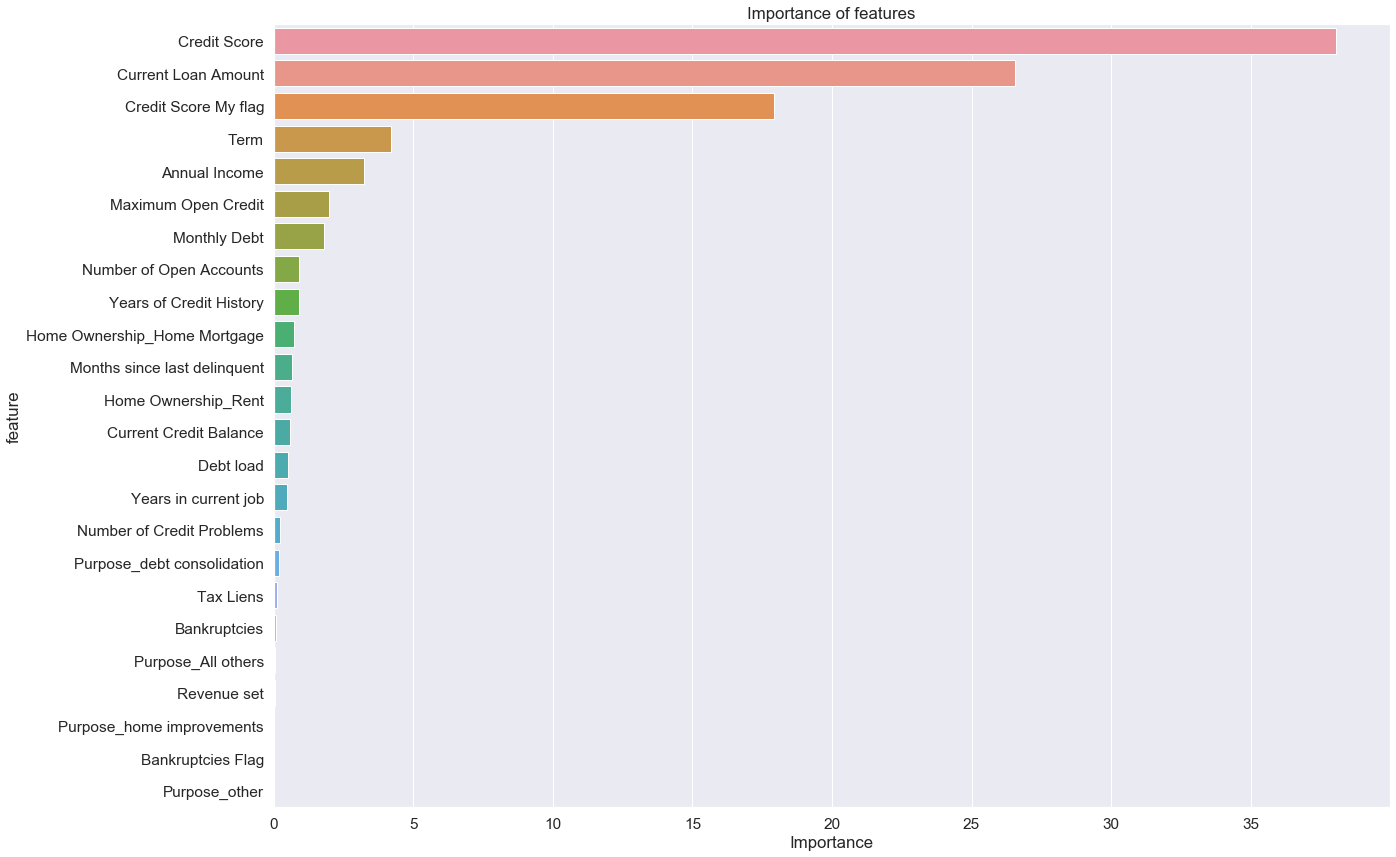

In [781]:
important_features_top15 = show_feature_importances(X_train.columns, 
                                                   final_model.feature_importances_, 
                                                   get_top=15
                                                  )

In [782]:
important_features_top7 = show_feature_importances(X_train.columns, 
                                                   final_model.feature_importances_, 
                                                   get_top=7, 
                                                   no_show_plt=True
                                                  )

Вот тут кончено забавно получается. Часть моих призакнов оказалось в самомом низу на уровне нуля. Попробую два варианта, тем более что это не очень сложно с 15 принзакми (не просто оставил как в уроке а поссмотрел когда вклада совсем нет)

И второй вариант с 7 признаким, до того как их вклад дальше совсем теряется

### Пред финальная модель с 15 и 7 признакми <a class="anchor" id="final_model"></a>

In [786]:
final_model15 = catb.CatBoostClassifier(n_estimators=200, max_depth=4, l2_leaf_reg=7,
                                      silent=True, random_state=43)

final_model15.fit(X_train[important_features_top15], y_train)

y_train_pred = final_model15.predict(X_train[important_features_top15])
y_test_pred = final_model15.predict(X_test[important_features_top15])
y_test_pred_probs = final_model15.predict_proba(X_test[important_features_top15])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      3795
           1       0.77      0.52      0.62      2910

    accuracy                           0.73      6705
   macro avg       0.74      0.70      0.70      6705
weighted avg       0.74      0.73      0.72      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1592
           1       0.61      0.48      0.54       658

    accuracy                           0.76      2250
   macro avg       0.71      0.68      0.69      2250
weighted avg       0.75      0.76      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1389  203
1                343  315


In [787]:
final_model7 = catb.CatBoostClassifier(n_estimators=200, max_depth=4, l2_leaf_reg=7,
                                      silent=True, random_state=43)

final_model7.fit(X_train[important_features_top7], y_train)

y_train_pred = final_model7.predict(X_train[important_features_top7])
y_test_pred = final_model7.predict(X_test[important_features_top7])
y_test_pred_probs = final_model7.predict_proba(X_test[important_features_top7])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      3795
           1       0.76      0.51      0.61      2910

    accuracy                           0.72      6705
   macro avg       0.73      0.69      0.69      6705
weighted avg       0.73      0.72      0.70      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1592
           1       0.58      0.49      0.53       658

    accuracy                           0.75      2250
   macro avg       0.69      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1362  230
1                338  320


Интересно кончено, борьба идет за буквально за 10-ок верных ответов. При этом общая оценка F1-Score сильно не изменилась. Не так как расчитывашь что будет не 0.54, а станет 0.8 или хотя бы 0.7 

В итоге остановлися на версии TOP15

И тут, ещё раз посмотрим с порогом что у нас

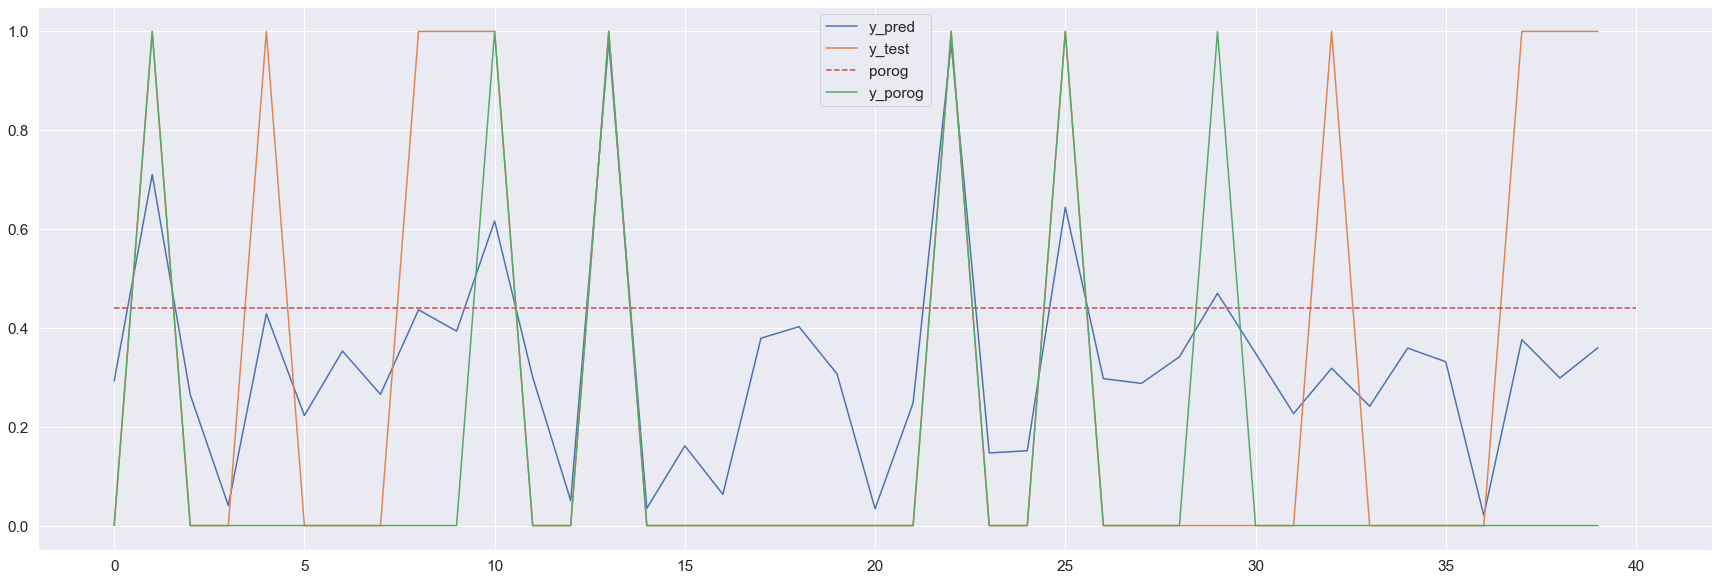

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      3795
           1       0.78      0.52      0.63      2910

    accuracy                           0.73      6705
   macro avg       0.74      0.70      0.71      6705
weighted avg       0.74      0.73      0.72      6705

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1592
           1       0.50      0.61      0.55       658

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1189  403
1                255  403


In [871]:
N=40
porog = 0.44
y_p = (y_test_pred_probs[:,1]>porog).astype(int)

plt.figure(figsize = (30,10))
plt.plot(y_test_pred_probs[:N,1], label='y_pred')
plt.plot(y_test[:N],label='y_test')
plt.plot([0,N],[porog,porog],'--r', label='porog')
plt.plot(y_p[:N],label='y_porog')
plt.legend()
plt.show()

# и посчитаем теперь какие у нас тсанут показатели
get_classification_report(y_train, y_train_pred, y_test, y_p)

Картина не сильно изменилась, потому оставлю такое значение 0.44

# Совсем финальная модель  <a class="anchor" id="final_model"></a>

Считаем снова подготовленные данные от греха подальше 

In [873]:
df = pd.read_csv(TRAIN_FULL_PATH)

Возьмем теперь выборку только нужных нам параметров из TOP15, по ним и будем строить подбор гипер параметров

In [791]:
X = df[important_features_top15]
y = df[TARGET_NAME]

При тестах у нас был параметры деревьев 200 и глубина 4, сделаем здесь около них, не залезая сильно глубоко 

In [792]:
params = {'n_estimators':[100, 150, 200, 250, 300, 400, 500],
          'max_depth':[3, 4, 5, 6, 7]}

In [793]:
cv=KFold(n_splits=3, random_state=43, shuffle=True)

In [794]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 30.7 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=43, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001A5E27EC0C8>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 400, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [795]:
rs.best_params_

{'n_estimators': 400, 'max_depth': 5}

In [797]:
rs.best_score_

0.541086573508496

Значение изменились, но результирующая F1-score не поменялась почти, думаю что это хорошо. Будем использовать новые Параметры

Проводим обучение модели непосредственно и сохраняем её

In [800]:
ffinal_model = catb.CatBoostClassifier(n_estimators=400, max_depth=5, l2_leaf_reg=7,
                                      silent=True, random_state=43)
ffinal_model.fit(X, y)

with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(ffinal_model, file)

# Делаем предсказания 

Грузим модель и дата сеты. Обнаружил небольшую проблему, в том как я избавляюсь от лишней переменной после DUMMY преобразования
Потому гружу ещё X_temp.

Вообще надо их добавить просто наверное отдельно в сохранение или как часть модели, но в следующий раз :)

In [881]:
with open(MODEL_FILE_PATH, 'rb') as file:
    model_load = pickle.load(file)    

In [882]:
X_in   = pd.read_csv(DATASET_TEST_PATH)
X_temp = pd.read_csv(DATASET_PATH)

In [883]:
for colname in X_in:
    my_prepare_dataset(X_in,colname)
    
    #это так
    my_prepare_dataset(X_temp,colname)
    
for colname in X_temp.select_dtypes(include=['object']).columns:    
    tmp_values = dict(X_temp[colname].value_counts().copy())
    nameslice_for_delet = list(tmp_values.keys())[len(tmp_values)-1]

    #А вот подготавливать уже нужно только на выборке где будем предсказывать, так как 
    X_in = my_dummy_prepare(X_in, colname,nameslice_for_delet)
    
BOOL_COL = ['Term','Revenue set','Bankruptcies Flag','Credit Score My flag']

for colname in BOOL_COL:            
    X_in[colname]      = X_in[colname].astype(bool)


In [884]:
X_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 25 columns):
Annual Income                   2500 non-null float64
Years in current job            2500 non-null int32
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    2500 non-null float64
Bankruptcies                    2500 non-null float64
Term                            2500 non-null bool
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    2500 non-null float64
Revenue set                     2500 non-null bool
Debt load                       2500 non-null float64
Bankruptcies Flag               2500 

Так как я не стал убирать признак с корреляцией высокой в итоге, то всё готово. 

In [896]:
#y_out = model_load.predict(X_in)
#Делаем предсказания частотными, чтобы применить свой порог

y_out = model_load.predict_proba(X_in)

In [897]:
porog = 0.44
y_out = (y_out[:,1]>porog).astype(int)

In [898]:
y_data = pd.DataFrame(y_out)
y_data.rename(columns={0: 'Credit Default'}, inplace=True)
y_data

,Credit Default
0,0
1,0
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0


Применим порог, который у нас подобрался опытным путем для максимизации F1-Score

Ну и сохраняем значение в CSV

In [899]:
y_data.to_csv('Andrew_S.csv', index=False, encoding='utf-8')

In [900]:
y_temp =pd.read_csv('Andrew_S.csv')
y_temp

,Credit Default
0,0
1,0
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0


P.S. Смотря уже в самом конце смотрел что я не поигрался c порогом, сначала не хотел возвращаться, но потом решил что надо попробовать, чтобы уже легло хорошо все в головое. И это оказалось хорошо :) 

Действительно инетерсно его двигать и смотреть, что отличия есть, хоть и не большие. 